In [61]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans22
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import warnings
warnings.filterwarnings('ignore')

In [62]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',   
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
#VOLUME_SLICES = 100  
VOLUME_SLICES = 48
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_DEPTH = 48
IMG_CHANNELS = 3

In [63]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'
# TRAIN_DATASET_PATH = '../input/brats2020-simples/'
# VALIDATION_DATASET_PATH = '../input/brats2020-simples/'

In [64]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

Text(0.5, 1.0, 'Mask')

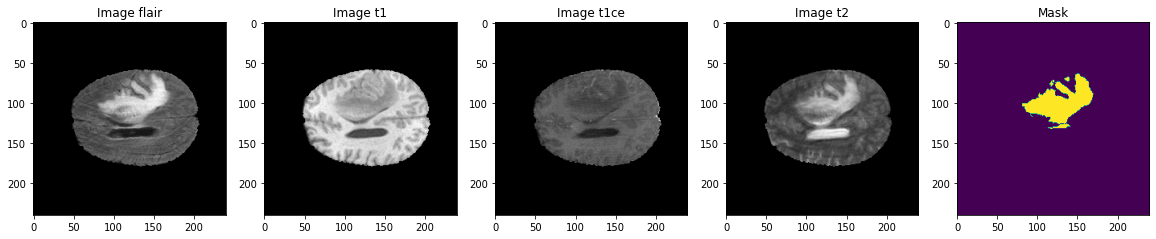

In [65]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

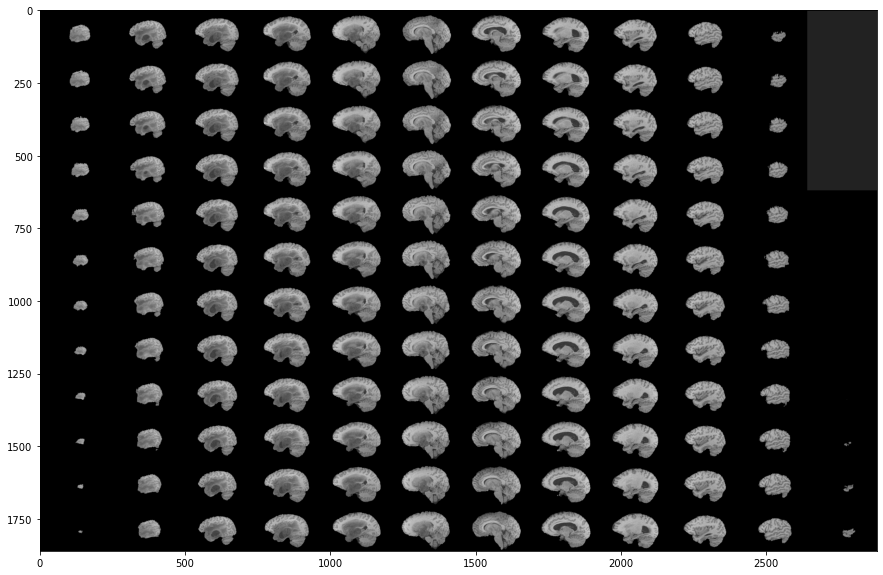

In [66]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

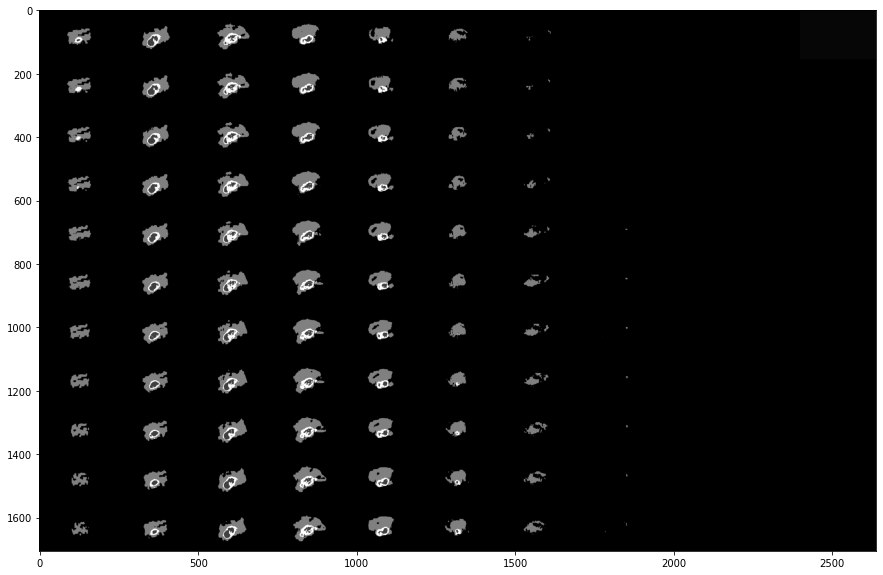

In [67]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

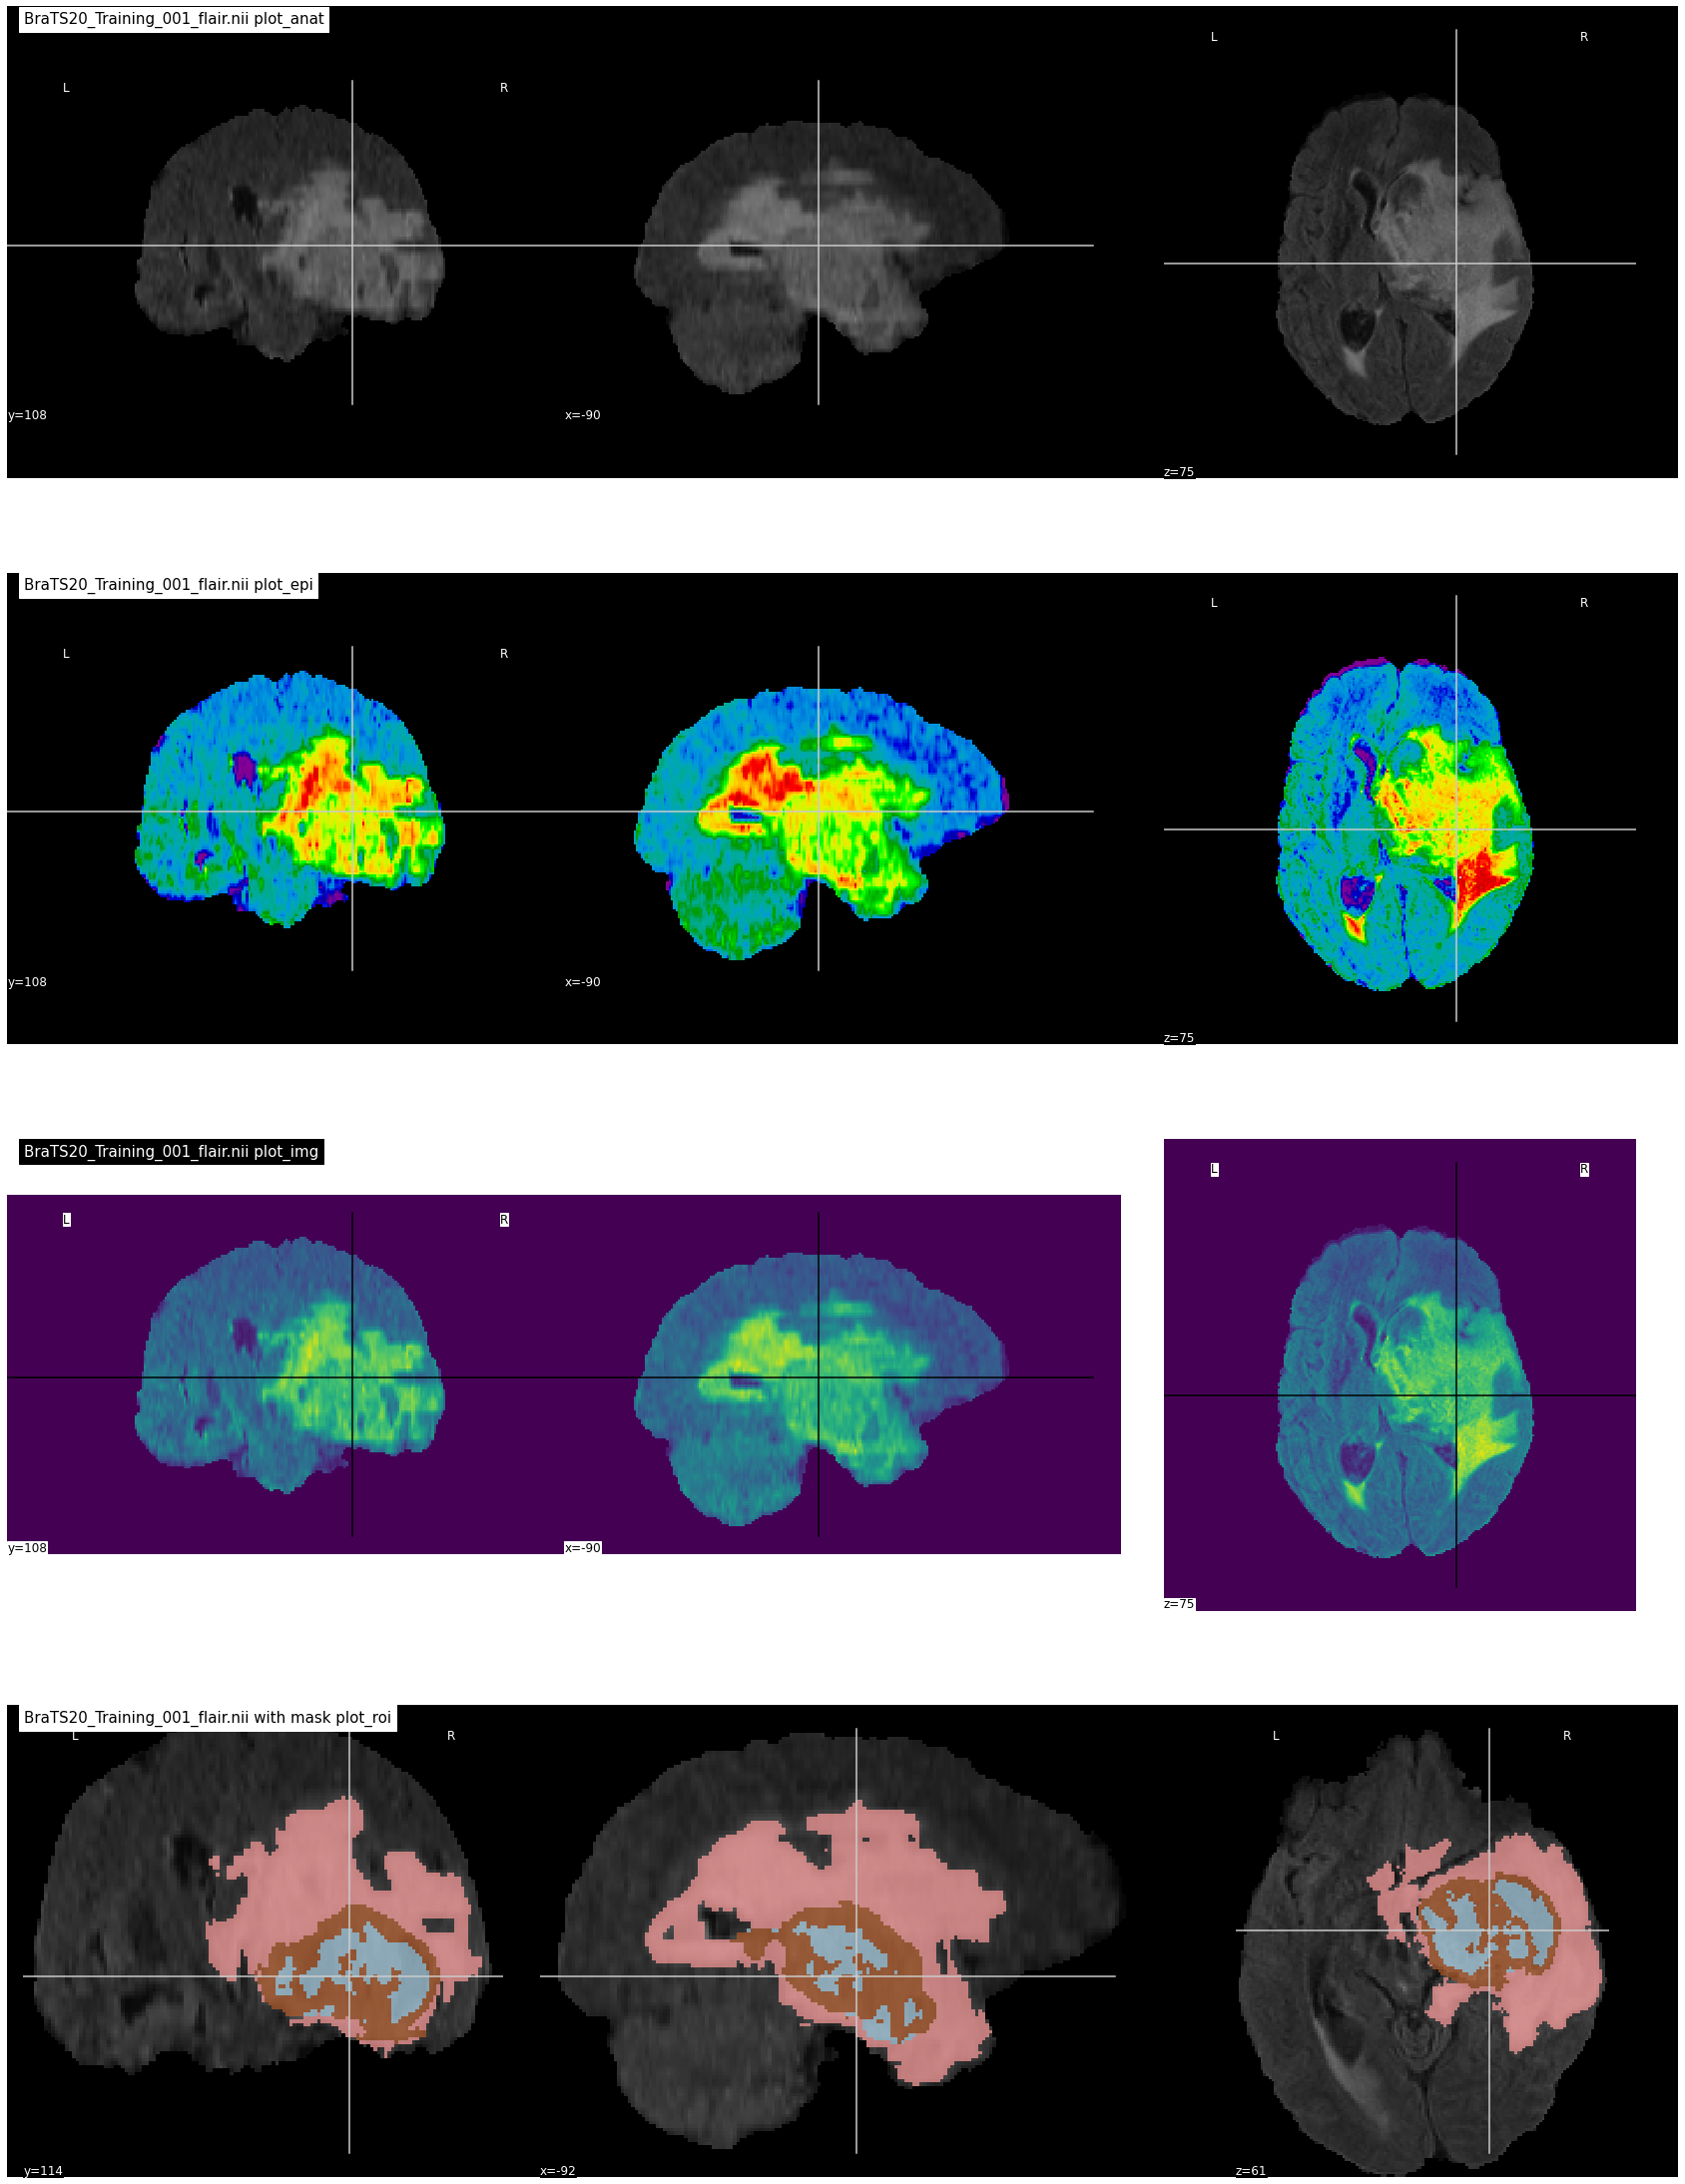

In [68]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [69]:
import tensorflow as tf
import numpy as np

# Dice Coefficient Metric
def dice_coef(y_true, y_pred, smooth=1e-9):
    y_pred = tf.cast(y_pred >= 0.5, dtype=tf.float32)  # Threshold predictions
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)

# Jaccard Index (IoU) Metric
def jaccard_coef(y_true, y_pred, smooth=1e-9):
    y_pred = tf.cast(y_pred >= 0.5, dtype=tf.float32)  # Threshold predictions
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)

# Precision Metric
def precision(y_true, y_pred):
    y_pred = tf.cast(y_pred >= 0.5, dtype=tf.float32)  # Threshold predictions
    true_positives = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    predicted_positives = tf.reduce_sum(y_pred, axis=[1, 2, 3])
    precision = true_positives / (predicted_positives + 1e-9)
    return tf.reduce_mean(precision)

# Sensitivity (Recall) Metric
def sensitivity(y_true, y_pred):
    y_pred = tf.cast(y_pred >= 0.5, dtype=tf.float32)  # Threshold predictions
    true_positives = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    actual_positives = tf.reduce_sum(y_true, axis=[1, 2, 3])
    sensitivity = true_positives / (actual_positives + 1e-9)
    return tf.reduce_mean(sensitivity)

# Specificity Metric
def specificity(y_true, y_pred):
    y_pred = tf.cast(y_pred >= 0.5, dtype=tf.float32)  # Threshold predictions
    true_negatives = tf.reduce_sum((1 - y_true) * (1 - y_pred), axis=[1, 2, 3])
    false_positives = tf.reduce_sum((1 - y_true) * y_pred, axis=[1, 2, 3])
    specificity = true_negatives / (true_negatives + false_positives + 1e-9)
    return tf.reduce_mean(specificity)

# Define Per-Class Dice Coefficients with Unique Names
def dice_coef_per_class(class_index, name):
    def dice_coef_class(y_true, y_pred):
        y_true_class = y_true[:, :, :, class_index]
        y_pred_class = y_pred[:, :, :, class_index]
        return dice_coef(y_true_class, y_pred_class)
    
    # Assign a unique name to the metric
    dice_coef_class.__name__ = name
    return dice_coef_class

# BCE + Dice Loss
def bce_dice_loss(y_true, y_pred):
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice_loss = 1.0 - dice_coef(y_true, y_pred)
    return bce_loss + dice_loss



In [70]:
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv3DTranspose, concatenate, Dropout, Input, Add
from tensorflow.keras.models import Model

def double_conv_block(x, filters, kernel_size=(3, 3, 3), padding='same', kernel_initializer='he_normal', dropout_rate=0.1):
    # First convolution
    x = Conv3D(filters, kernel_size, activation='relu', padding=padding, kernel_initializer=kernel_initializer)(x)
    x = Dropout(dropout_rate)(x)
    # Second convolution
    x = Conv3D(filters, kernel_size, activation='relu', padding=padding, kernel_initializer=kernel_initializer)(x)
    x = Dropout(dropout_rate)(x)
    return x

def residual_block(x, filters, kernel_size=(3, 3, 3), padding='same', kernel_initializer='he_normal', dropout_rate=0.1):
    # Double convolution
    conv_out = double_conv_block(x, filters, kernel_size, padding, kernel_initializer, dropout_rate)
    # Residual connection
    residual = Conv3D(filters, (1, 1, 1), padding=padding, kernel_initializer=kernel_initializer)(x)
    out = Add()([conv_out, residual])
    return out

def build_unet(inputs, ker_init):
    num_classes = 4
    s = inputs  # (IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS)

    # Contraction path
    c1 = residual_block(s, 16, kernel_size=(3, 3, 3), kernel_initializer=ker_init, dropout_rate=0.1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = residual_block(p1, 32, kernel_size=(3, 3, 3), kernel_initializer=ker_init, dropout_rate=0.1)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = residual_block(p2, 64, kernel_size=(3, 3, 3), kernel_initializer=ker_init, dropout_rate=0.2)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = residual_block(p3, 128, kernel_size=(3, 3, 3), kernel_initializer=ker_init, dropout_rate=0.2)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = residual_block(p4, 256, kernel_size=(3, 3, 3), kernel_initializer=ker_init, dropout_rate=0.3)
    
    # Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = residual_block(u6, 128, kernel_size=(3, 3, 3), kernel_initializer=ker_init, dropout_rate=0.2)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = residual_block(u7, 64, kernel_size=(3, 3, 3), kernel_initializer=ker_init, dropout_rate=0.2)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = residual_block(u8, 32, kernel_size=(3, 3, 3), kernel_initializer=ker_init, dropout_rate=0.1)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = residual_block(u9, 16, kernel_size=(3, 3, 3), kernel_initializer=ker_init, dropout_rate=0.1)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    
    return model

# Define input layer
input_layer = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, 3))
model = build_unet(input_layer, 'he_normal')

# Compile the model
model.compile(
    loss=bce_dice_loss,  # Use your custom loss function
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_per_class(0, "dice_coef_necrotic"),  # Necrotic Core
        dice_coef_per_class(1, "dice_coef_edema"),     # Peritumoral Edema
        dice_coef_per_class(2, "dice_coef_enhancing"), # Enhancing Tumor
        jaccard_coef
    ]
)

print(model.input_shape)
print(model.output_shape)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 48 0                                            
__________________________________________________________________________________________________
conv3d_56 (Conv3D)              (None, 128, 128, 48, 1312        input_3[0][0]                    
__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 128, 128, 48, 0           conv3d_56[0][0]                  
__________________________________________________________________________________________________
conv3d_57 (Conv3D)              (None, 128, 128, 48, 6928        dropout_36[0][0]                 
____________________________________________________________________________________________

In [71]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
#train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [87]:
my_test_ids = ['BraTS20_Training_319', 'BraTS20_Training_252', 'BraTS20_Training_195', 'BraTS20_Training_163', 'BraTS20_Training_213', 'BraTS20_Training_209', 'BraTS20_Training_337', 'BraTS20_Training_058', 'BraTS20_Training_278', 'BraTS20_Training_025', 'BraTS20_Training_143', 'BraTS20_Training_193', 'BraTS20_Training_008', 'BraTS20_Training_024', 'BraTS20_Training_219', 'BraTS20_Training_266', 'BraTS20_Training_282', 'BraTS20_Training_097', 'BraTS20_Training_217', 'BraTS20_Training_153', 'BraTS20_Training_299', 'BraTS20_Training_035', 'BraTS20_Training_349', 'BraTS20_Training_129', 'BraTS20_Training_115', 'BraTS20_Training_002', 'BraTS20_Training_311', 'BraTS20_Training_265', 'BraTS20_Training_231', 'BraTS20_Training_020', 'BraTS20_Training_031', 'BraTS20_Training_036', 'BraTS20_Training_131', 'BraTS20_Training_204', 'BraTS20_Training_347', 'BraTS20_Training_155', 'BraTS20_Training_161', 'BraTS20_Training_041', 'BraTS20_Training_107', 'BraTS20_Training_296', 'BraTS20_Training_047', 'BraTS20_Training_238', 'BraTS20_Training_322', 'BraTS20_Training_016', 'BraTS20_Training_060']

In [72]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Define the output directory path
output_dir = '/kaggle/working/'

# Function to save IDs to a text file in the output directory
def save_ids_to_file(ids, file_name):
    file_path = os.path.join(output_dir, file_name)
    with open(file_path, 'w') as file:
        for id_ in ids:
            file.write(id_ + '\n')

# Print the number of images in each set
print("Number of images in training set:", len(train_ids))
print("Number of images in validation set:", len(val_ids))
print("Number of images in test set:", len(test_ids))


Number of images in training set: 249
Number of images in validation set: 74
Number of images in test set: 45


In [73]:
def ResizeAndReduceSlices(nib,size,slices,gap):
    imgs = []
    for i in range(128):
        list1 = []
        for j in range(128):
            list2 = []
            for k in range(48):
                list2.append(0)
            list1.append(list2)
        imgs.append(list1)
    imgs = np.array(imgs)
    for i in range(slices):
        imgs[:,:,i] = cv2.resize(nib[:,:,int((i*gap)+20)],(size,size))
    return imgs

In [88]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH), batch_size = 1, n_channels = 3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size, *self.dim, self.n_channels)) # shape of (5, 128, 128, 128, 3)
        #y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size, *self.dim)) # shape of (5, 128, 128, 128)
        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata() 

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t2.nii'); 
            t2 = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            #seg=seg.astype(np.uint8)
            #seg[seg==4] = 3

            #temp_combined_images = np.stack([flair, ce, t2], axis=3)
            #temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
            #temp_mask = seg[56:184, 56:184, 13:141]
            
            slice_w = 25

            # (j +VOLUME_SLICES*c) 
            for j in range(VOLUME_SLICES):
                X[c,:,:,j,0] = cv2.resize(flair[:,:,VOLUME_START_AT+int(j*2.5)], (IMG_HEIGHT, IMG_WIDTH));
                X[c,:,:,j,1] = cv2.resize(ce[:,:,VOLUME_START_AT+int(j*2.5)], (IMG_HEIGHT, IMG_WIDTH));
                X[c,:,:,j,2] = cv2.resize(t2[:,:,VOLUME_START_AT+int(j*2.5)], (IMG_HEIGHT, IMG_WIDTH));

                #y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                Y[c,:,:,j] = cv2.resize(seg[:,:,VOLUME_START_AT+int(j*2.5)], (IMG_HEIGHT, IMG_WIDTH));
                    
        # Generate masks
        #y[y==4] = 3;
        Y[Y==4] = 3;
        mask = tf.one_hot(Y, 4);
        #Y = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH));
        return X/np.max(X), mask
        #return temp_combined_images/np.max(temp_combined_images), temp_mask
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)
my_test_generator=DataGenerator(my_test_ids)

249
74
45
249
74
45
(128, 128, 48)


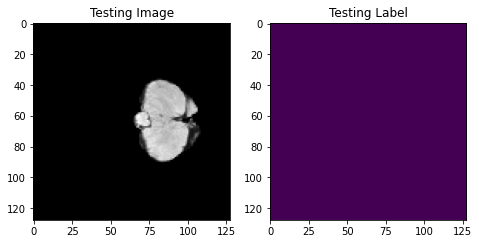

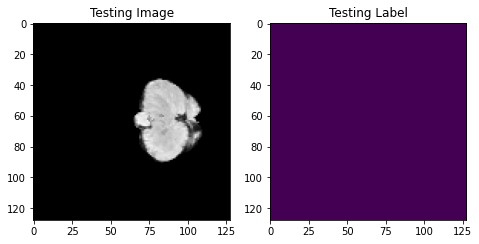

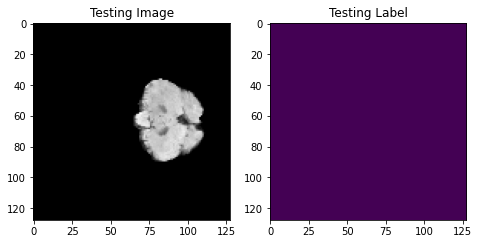

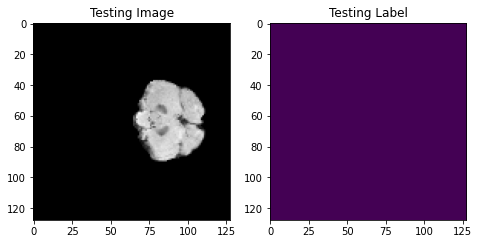

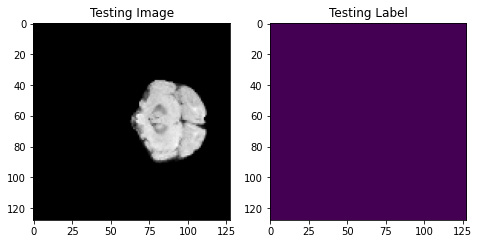

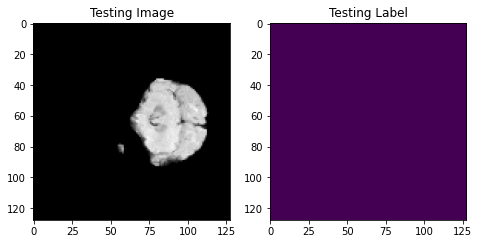

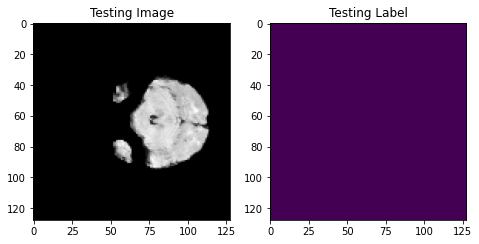

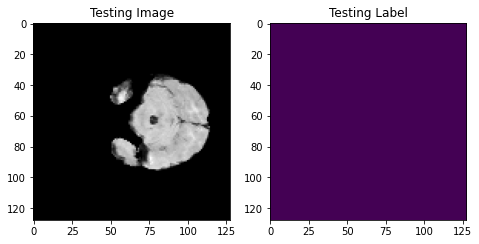

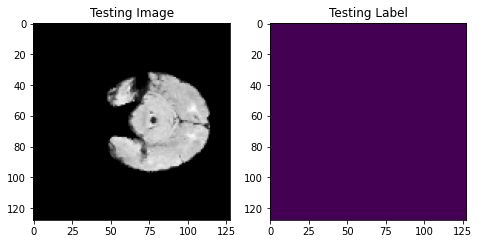

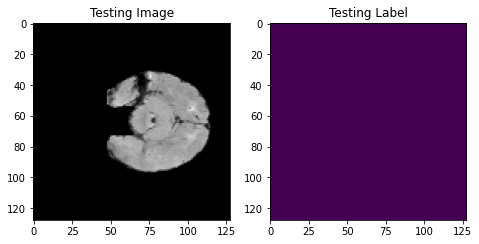

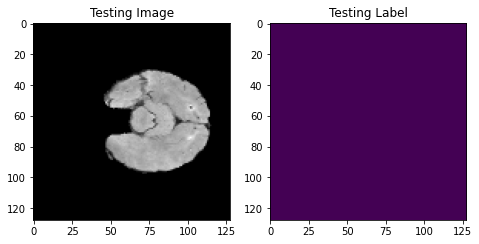

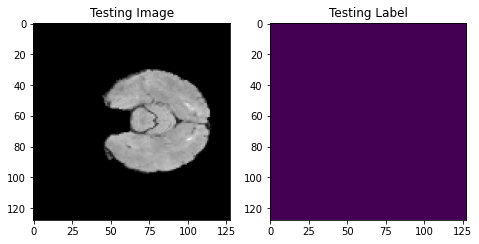

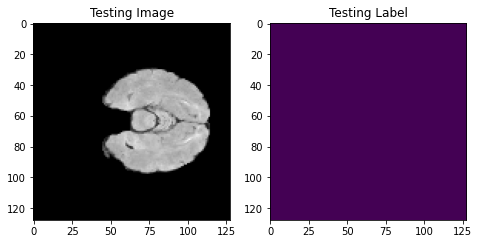

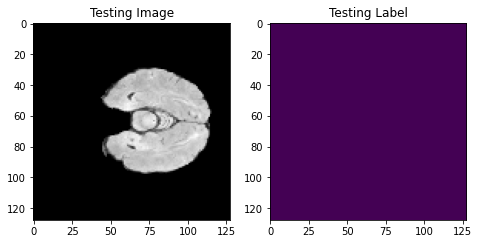

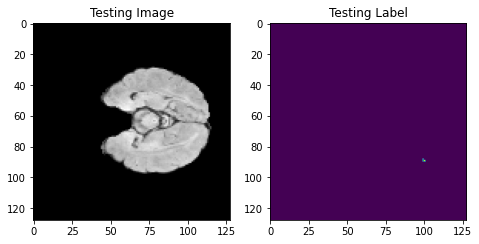

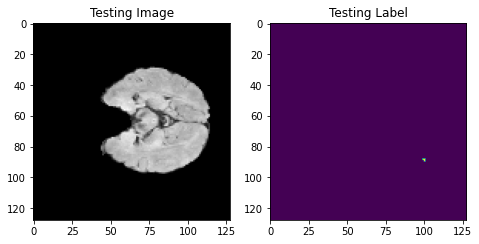

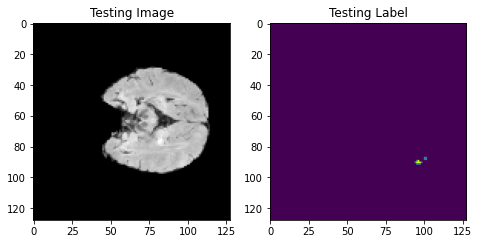

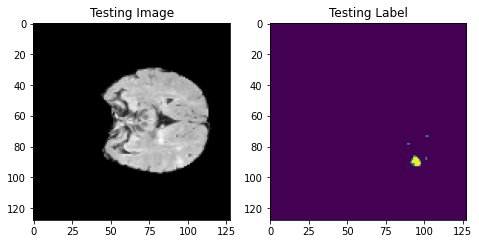

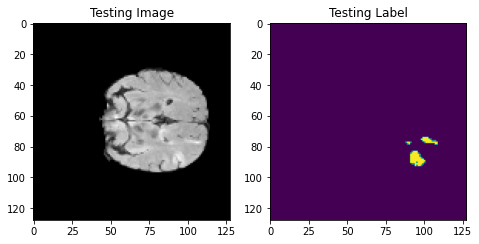

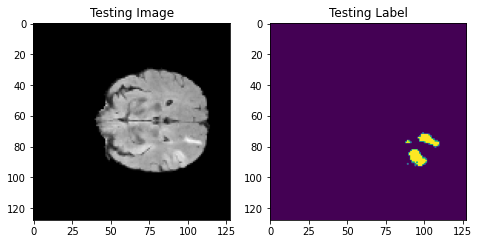

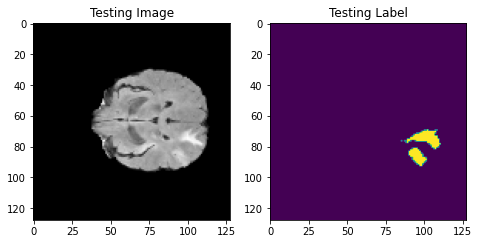

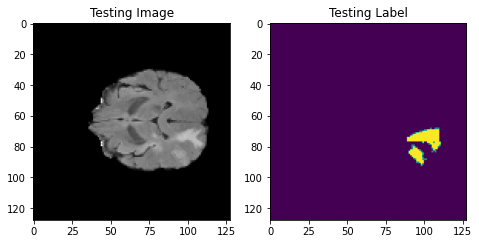

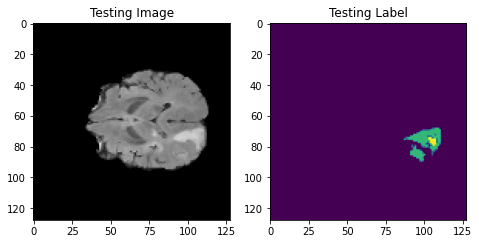

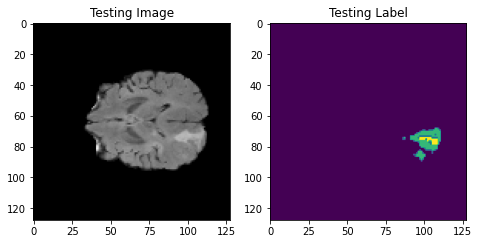

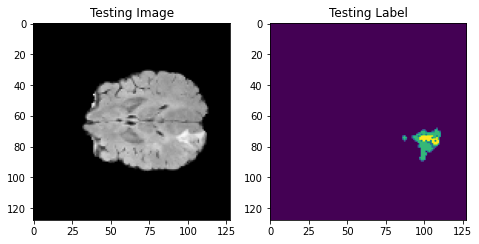

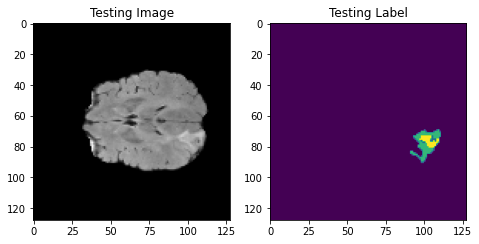

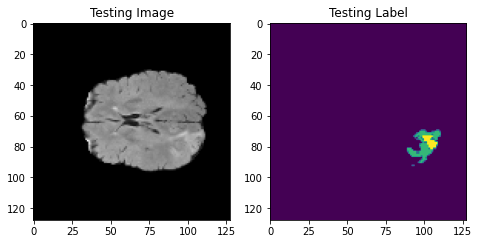

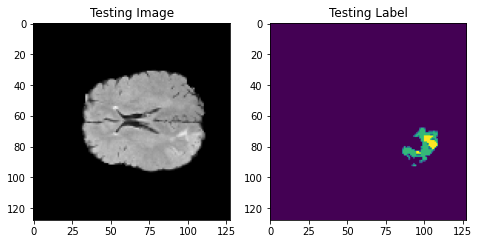

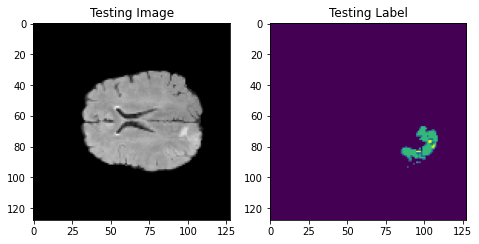

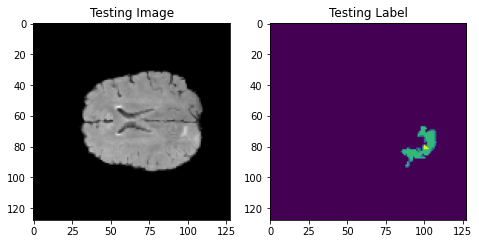

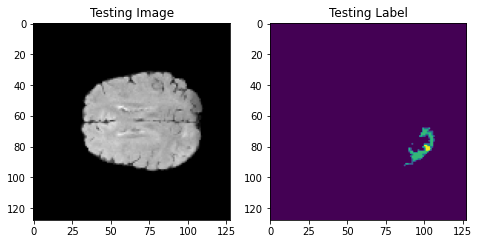

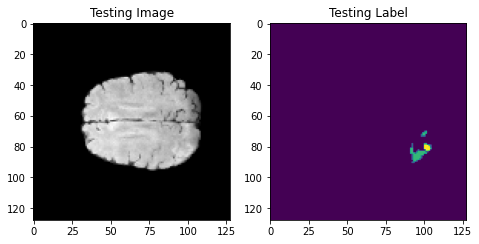

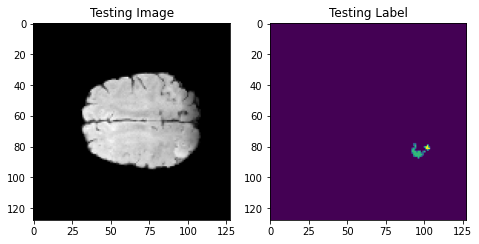

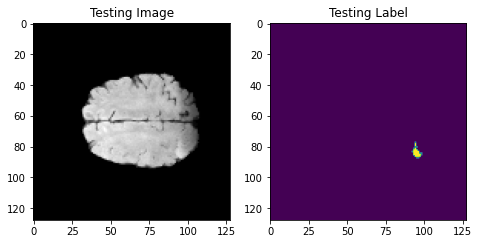

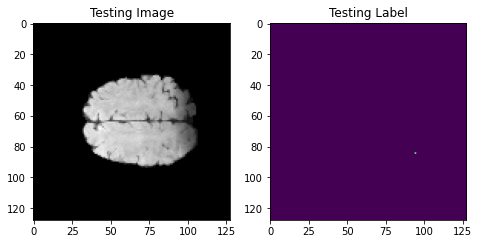

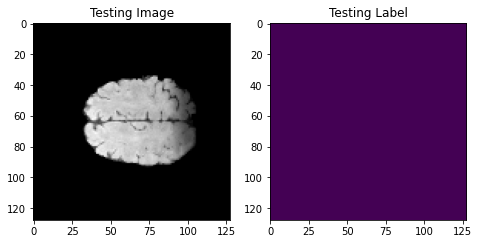

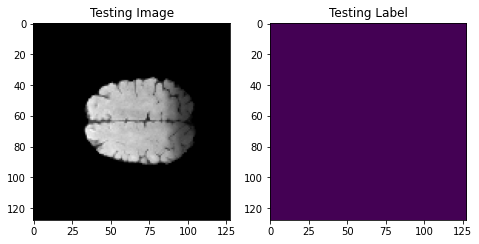

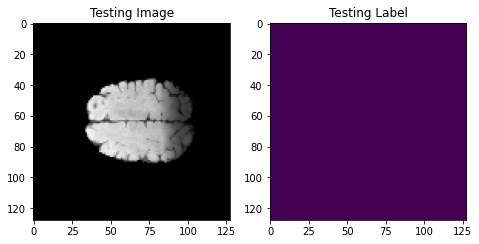

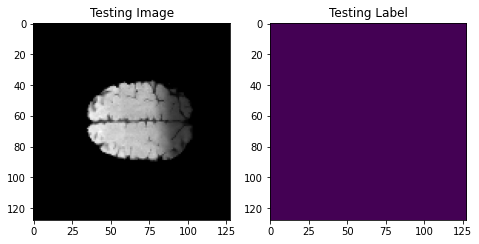

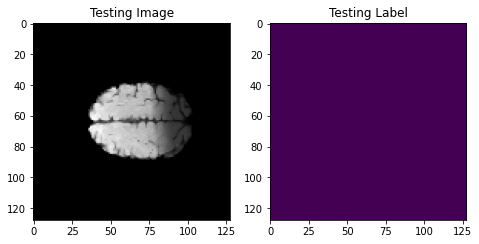

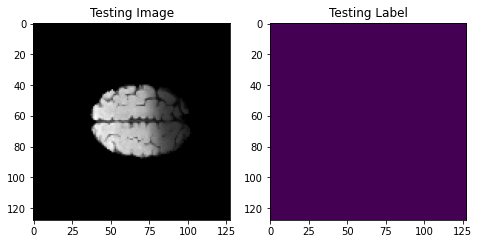

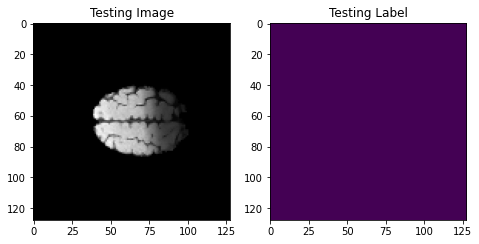

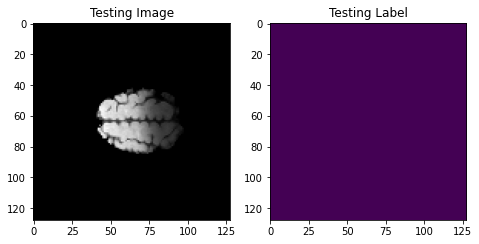

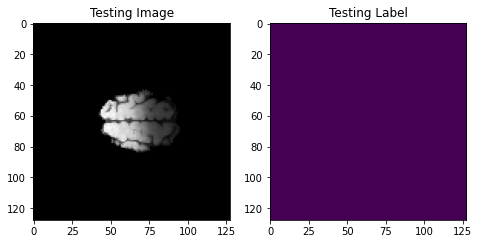

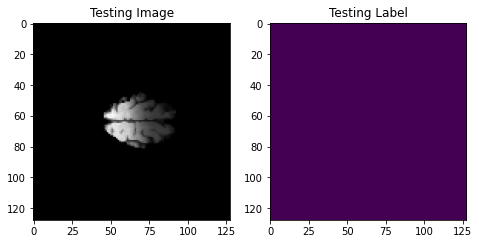

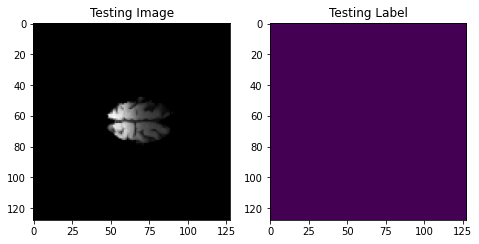

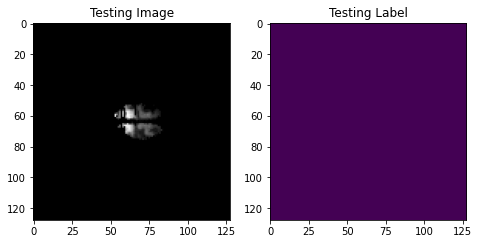

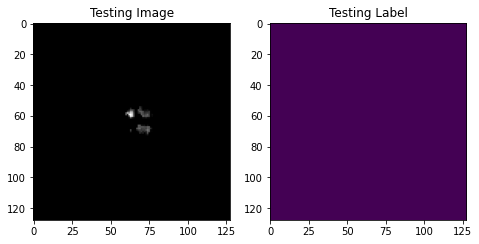

In [75]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))
print(len(training_generator))
print(len(valid_generator))
print(len(test_generator))
img, mask = test_generator[0]
mask=np.argmax(mask, axis=4)[0,:,:,:]
print(mask.shape)
for n_slice in range(48):
# n_slice = 24
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(img[0,:,:,n_slice,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(mask[:,:,n_slice])

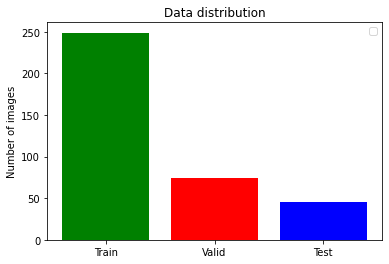

In [76]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.savefig('data2020.png')
    plt.show()
    
showDataLayout()

In [77]:
history =  model.fit(training_generator,
                    epochs=50,
                    steps_per_epoch=len(train_ids),
                    validation_data = valid_generator
                    )

Epoch 1/50
249/249 [==============================] - 95s 371ms/step - loss: 0.7971 - accuracy: 0.9773 - mean_io_u_8: 0.8087 - dice_coef: 0.2600 - precision: 0.2807 - sensitivity: 0.2471 - specificity: 0.7600 - dice_coef_necrotic: 0.9744 - dice_coef_edema: 0.9807 - dice_coef_enhancing: 0.9816 - jaccard_coef: 0.2566 - val_loss: 0.7651 - val_accuracy: 0.9842 - val_mean_io_u_8: 0.8063 - val_dice_coef: 0.2661 - val_precision: 0.2999 - val_sensitivity: 0.2528 - val_specificity: 0.7792 - val_dice_coef_necrotic: 1.0000 - val_dice_coef_edema: 1.0000 - val_dice_coef_enhancing: 0.9999 - val_jaccard_coef: 0.2621
Epoch 2/50
249/249 [==============================] - 89s 356ms/step - loss: 0.7501 - accuracy: 0.9866 - mean_io_u_8: 0.8507 - dice_coef: 0.2742 - precision: 0.3364 - sensitivity: 0.2555 - specificity: 0.7887 - dice_coef_necrotic: 0.9999 - dice_coef_edema: 0.9999 - dice_coef_enhancing: 0.9996 - jaccard_coef: 0.2689 - val_loss: 0.7224 - val_accuracy: 0.9847 - val_mean_io_u_8: 0.8388 - val_

In [78]:
model.save("model_my_3D_UNet.h5")

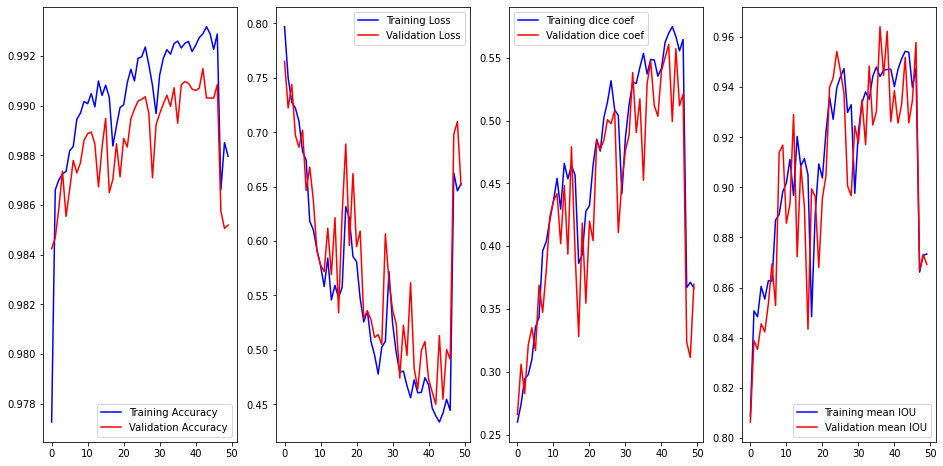

In [80]:
############ load trained model ################
model = tf.keras.models.load_model(
    '/kaggle/working/model_my_3D_UNet.h5',
    custom_objects={
        'MeanIoU': tf.keras.metrics.MeanIoU(num_classes=4),  # Use 'MeanIoU' instead of 'accuracy'
        'dice_coef': dice_coef,
        'precision': precision,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'dice_coef_necrotic': dice_coef_per_class(0, "dice_coef_necrotic"),  # Necrotic Core (class 0)
        'dice_coef_edema': dice_coef_per_class(1, "dice_coef_edema"),         # Peritumoral Edema (class 1)
        'dice_coef_enhancing': dice_coef_per_class(2, "dice_coef_enhancing")  # Enhancing Tumor (class 2)
    },
    compile=False  # Do not compile the model during loading
)



hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u_8'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u_8'],'r',label='Validation mean IOU')
ax[3].legend()
plt.savefig('training_result_2018.png')
plt.show()

In [ ]:
print(hist)


In [89]:
model = tf.keras.models.load_model(
    '/kaggle/working/model_my_3D_UNet.h5',
    custom_objects={
        'MeanIoU': tf.keras.metrics.MeanIoU(num_classes=4),  # Use 'MeanIoU' instead of 'accuracy'
        'dice_coef': dice_coef,
        'precision': precision,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'dice_coef_necrotic': dice_coef_per_class(0, "dice_coef_necrotic"),  # Necrotic Core (class 0)
        'dice_coef_edema': dice_coef_per_class(1, "dice_coef_edema"),         # Peritumoral Edema (class 1)
        'dice_coef_enhancing': dice_coef_per_class(2, "dice_coef_enhancing")  # Enhancing Tumor (class 2)
    },
    compile=False  # Do not compile the model during loading
)
model.compile(
    loss=bce_dice_loss,  # Use your custom loss function
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_per_class(0, "dice_coef_necrotic"),  # Necrotic Core
        dice_coef_per_class(1, "dice_coef_edema"),     # Peritumoral Edema
        dice_coef_per_class(2, "dice_coef_enhancing"), # Enhancing Tumor
        jaccard_coef
    ]
)
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100)
print("test loss, test acc:", results)

Evaluate on test data
45/45 [==============================] - 10s 187ms/step - loss: 0.6168 - accuracy: 0.9886 - mean_io_u_14: 0.8725 - dice_coef: 0.4001 - precision: 0.5556 - sensitivity: 0.3729 - specificity: 0.8604 - dice_coef_necrotic: 1.0000 - dice_coef_edema: 1.0000 - dice_coef_enhancing: 1.0000 - jaccard_coef: 0.3583
test loss, test acc: [0.6168486475944519, 0.9886361360549927, 0.8724974393844604, 0.40009361505508423, 0.5555606484413147, 0.372859925031662, 0.8604112267494202, 1.0, 1.0, 0.9999634027481079, 0.3582872748374939]


test_prediction_shape: (1, 128, 128, 48, 4)
test_prediction_argmax_shape: (128, 128, 48)
[0 2 3]
test_img_shape: (1, 128, 128, 48, 3)
test_mask_shape: (1, 128, 128, 48, 4)
test_mask_argmax: (128, 128, 48)


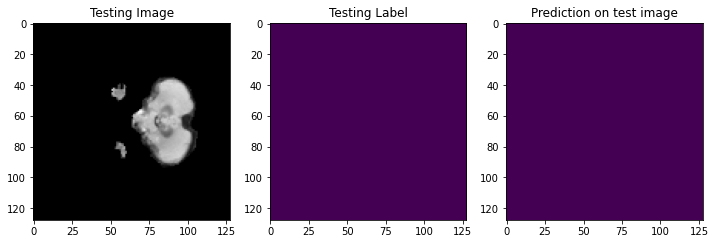

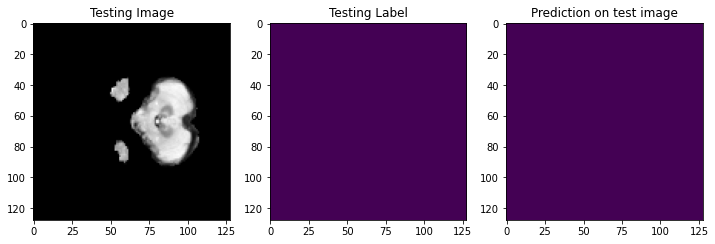

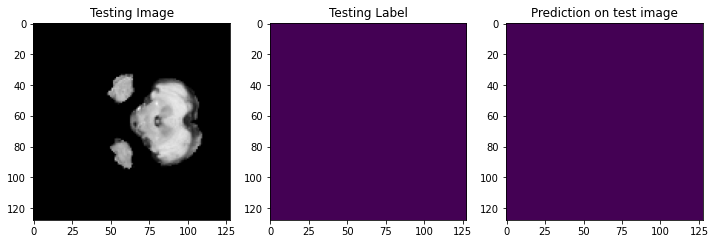

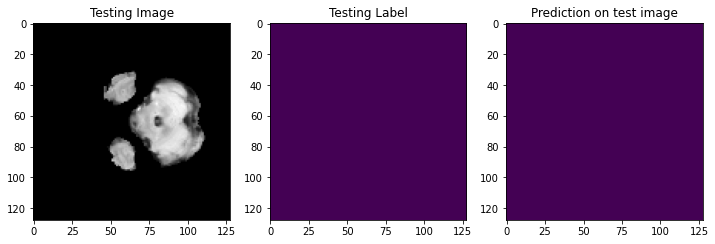

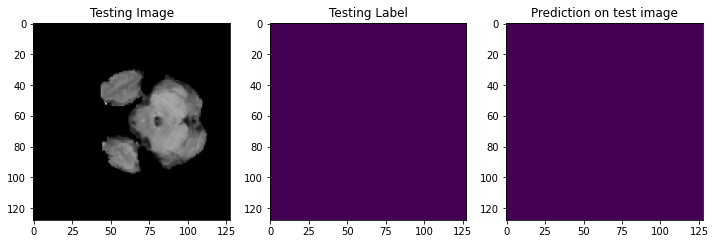

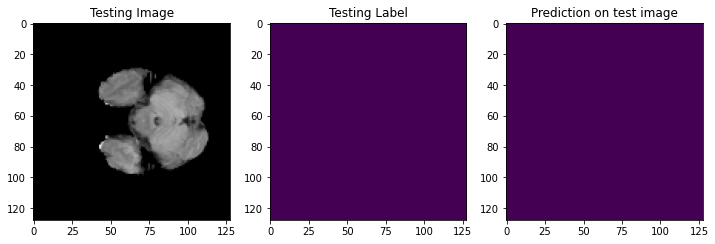

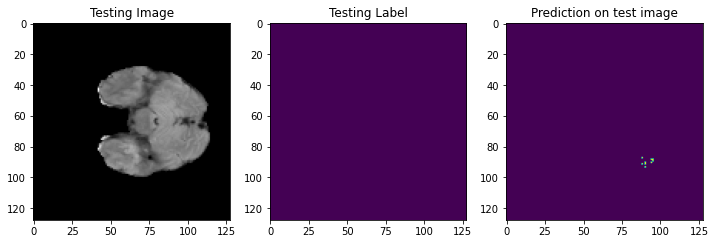

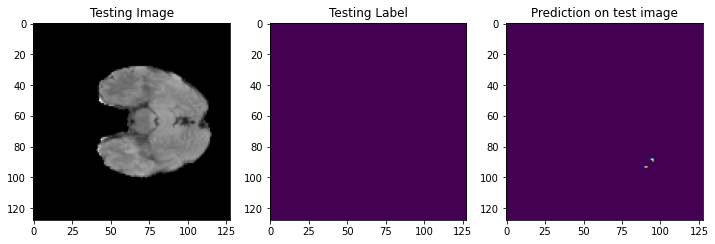

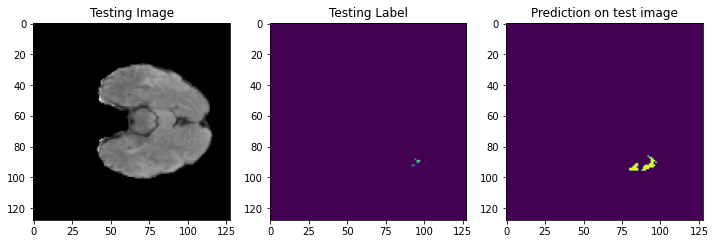

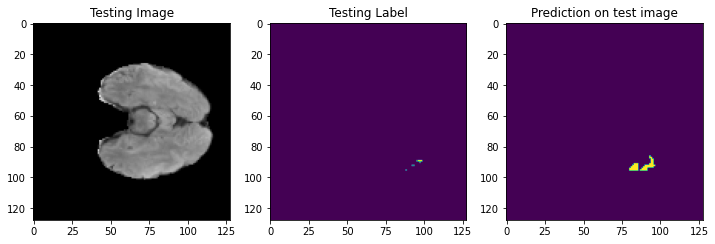

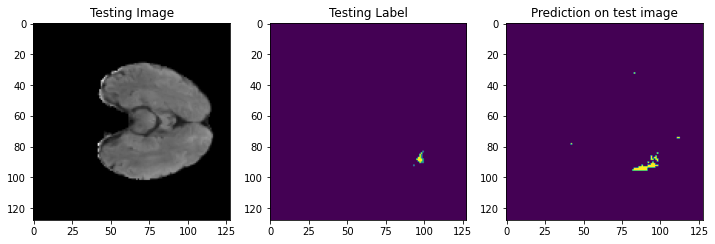

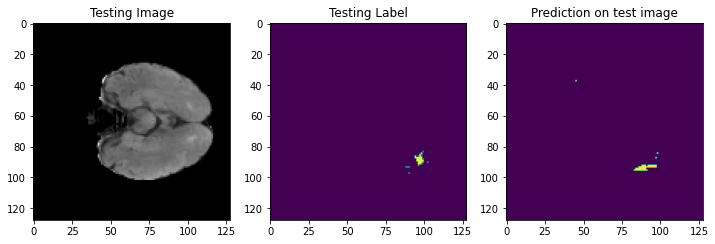

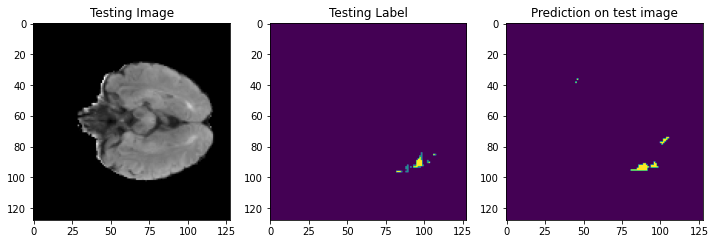

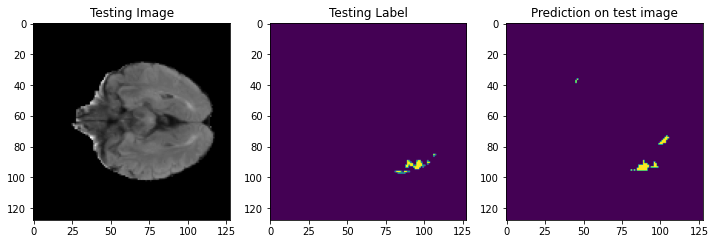

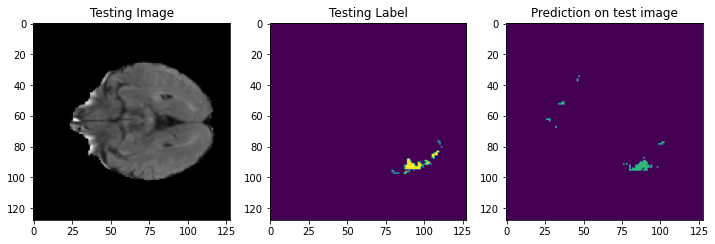

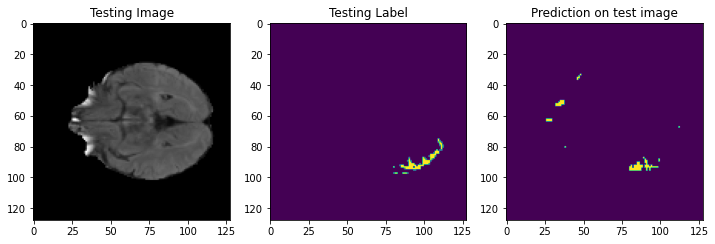

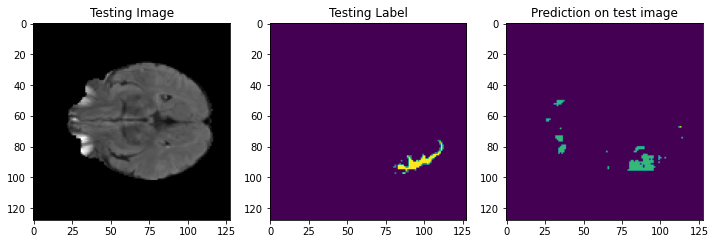

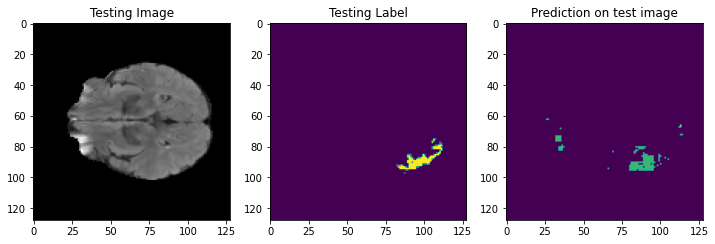

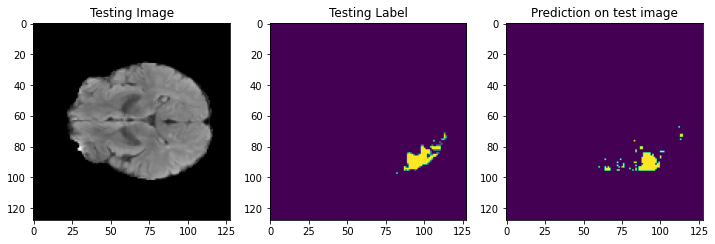

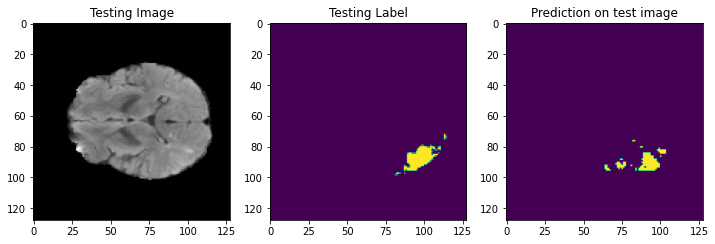

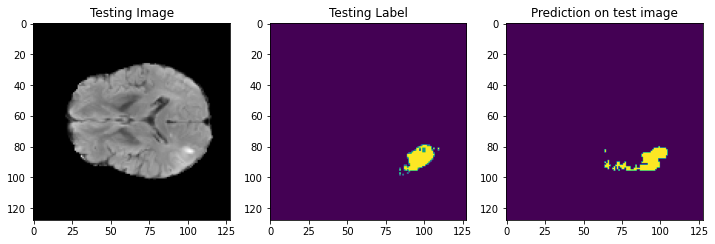

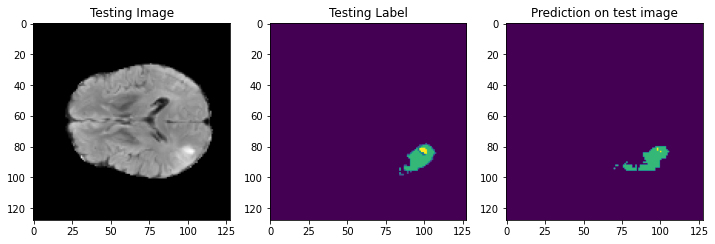

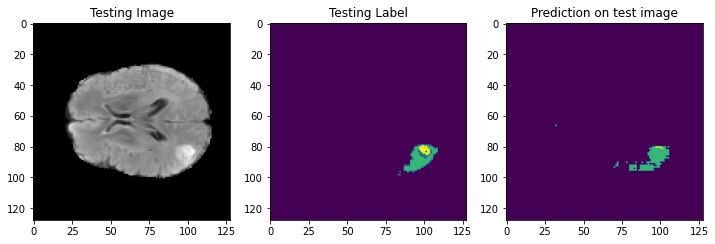

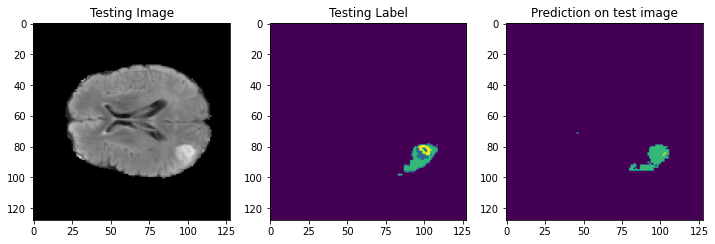

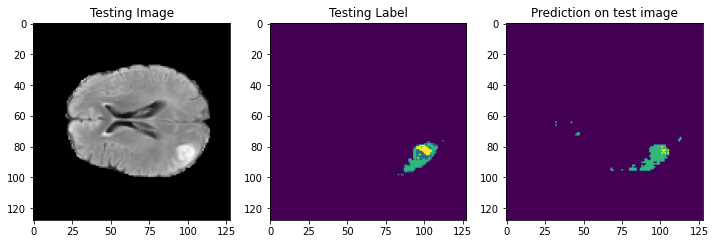

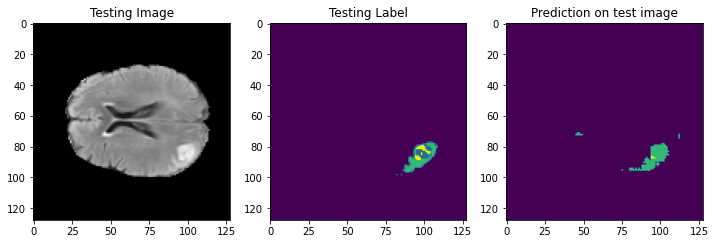

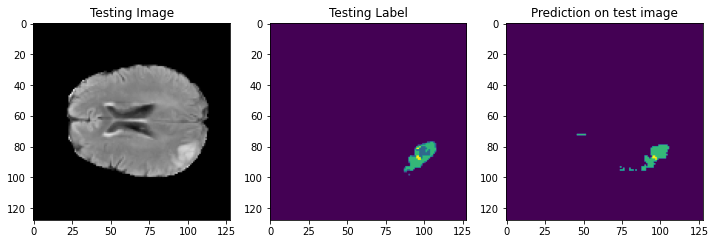

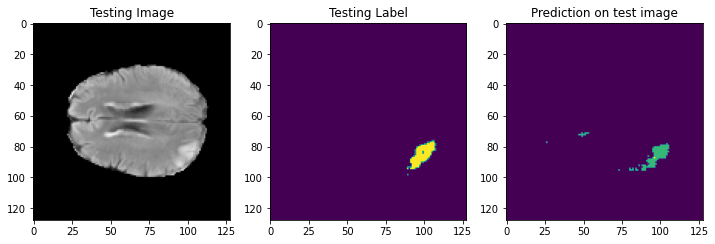

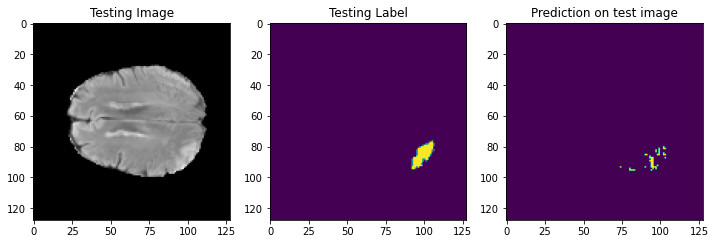

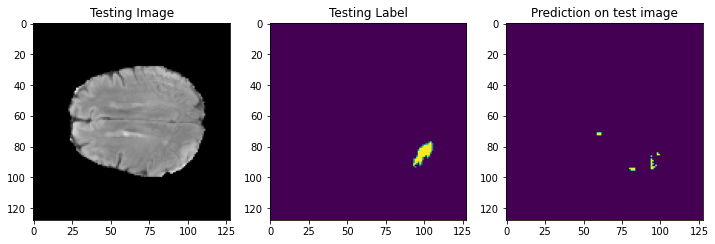

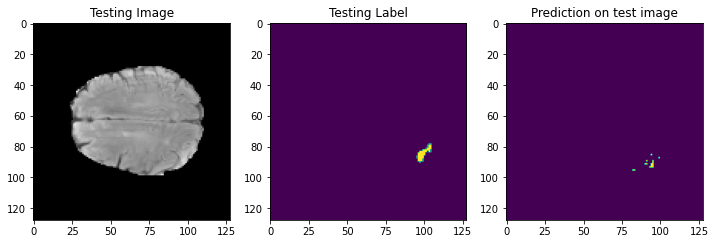

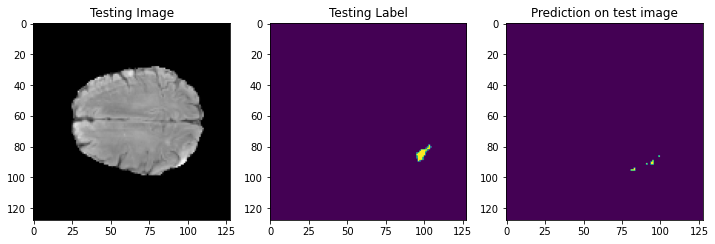

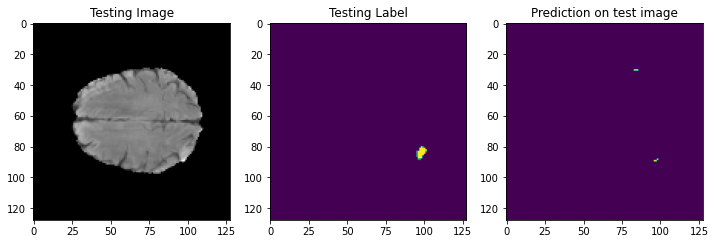

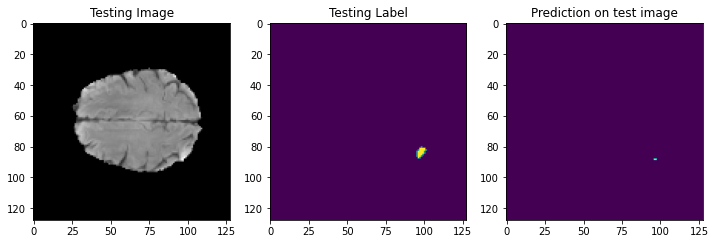

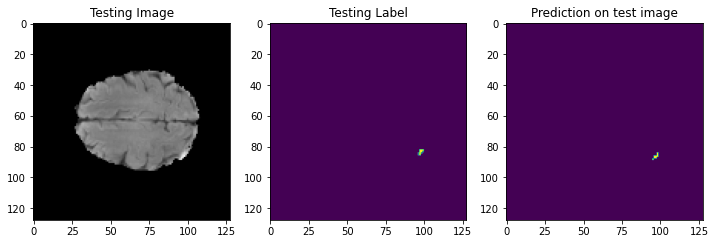

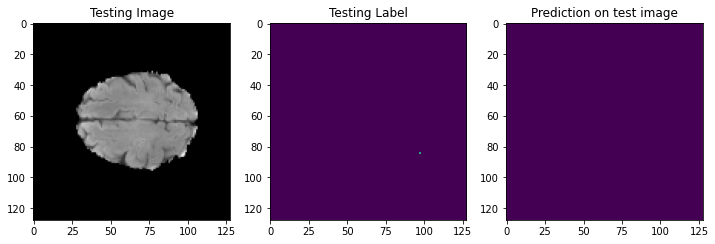

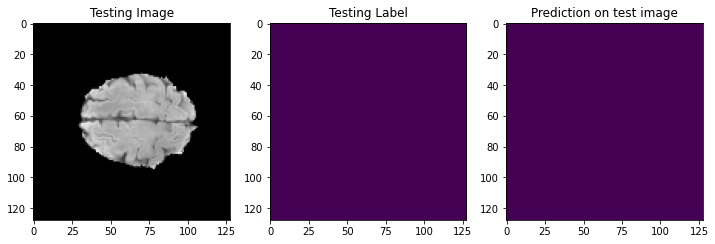

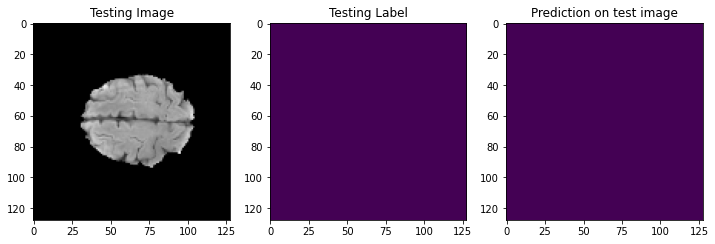

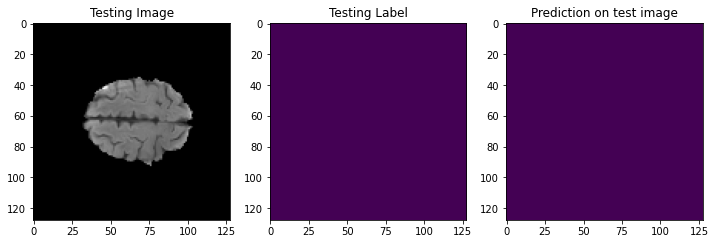

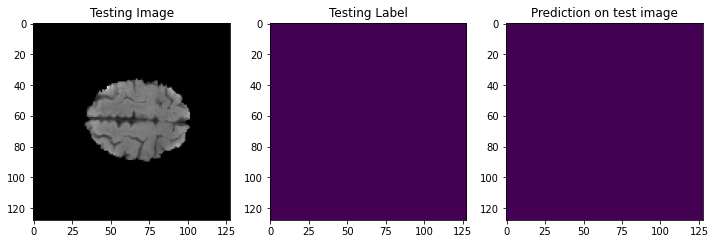

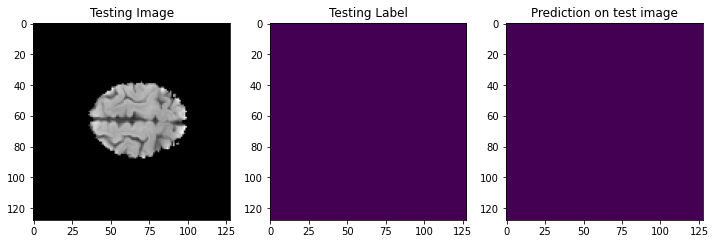

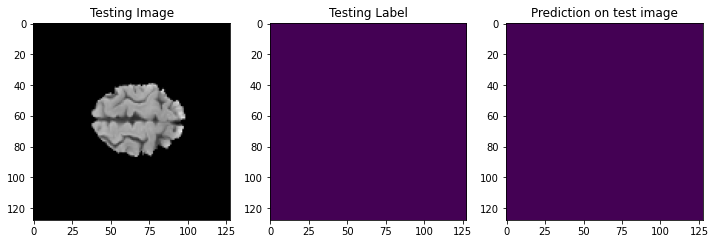

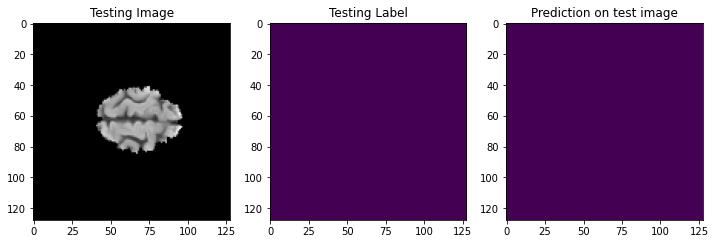

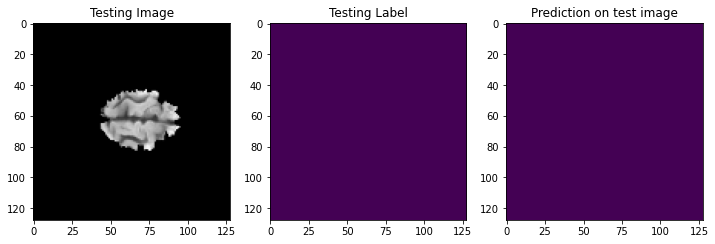

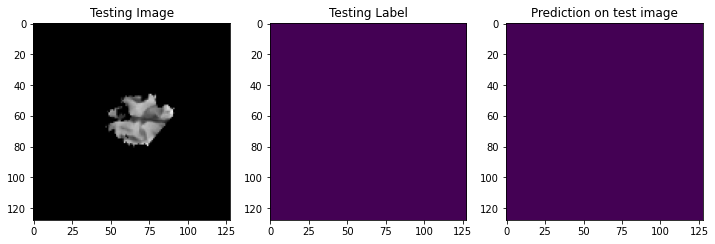

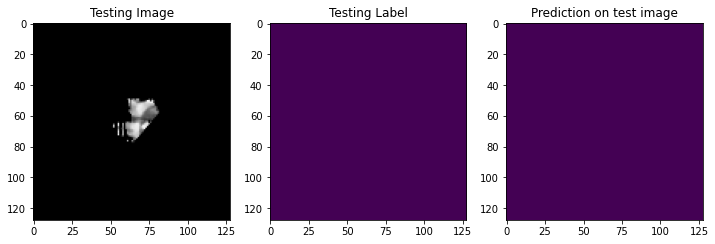

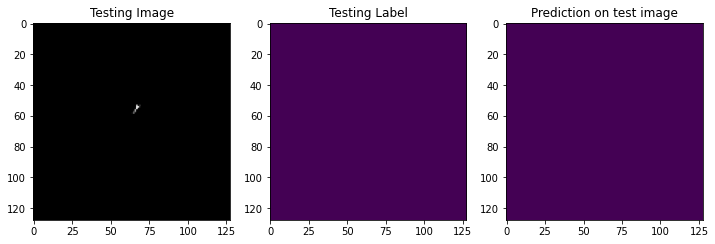

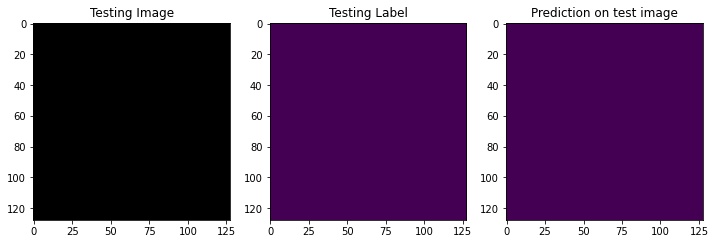

In [90]:
# DataGenerator(ex: test_generator)=>tuple(images,mask)
# images=>[slice,depth,width,height,channels]
# mask=>[slice,depth,width,height,labels]

img_num = 33
test_img = test_generator.__getitem__(img_num)[0]    #tuple(image,mask) -> 0: image
test_mask = test_generator.__getitem__(img_num)[1]   #tuple(image,mask) -> 1: mask
test_mask_argmax=np.argmax(test_mask, axis=4)[0,:,:,:]

test_prediction = model.predict(test_img)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

print("test_prediction_shape: " + str(test_prediction.shape))
print("test_prediction_argmax_shape: " + str(test_prediction_argmax.shape))
print(np.unique(test_prediction_argmax))
print("test_img_shape: " + str(test_img.shape))
print("test_mask_shape: " + str(test_mask.shape))
print("test_mask_argmax: " + str(test_mask_argmax.shape))

n_slice = 15
for n_slice in range(48):
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[0,:,:,n_slice,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(test_mask_argmax[:,:,n_slice])
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(test_prediction_argmax[:,:,n_slice])
    plt.show()

test_prediction_shape: (1, 128, 128, 48, 4)
test_prediction_argmax_shape: (128, 128, 48)
[0 1 2]
test_img_shape: (1, 128, 128, 48, 3)
test_mask_shape: (1, 128, 128, 48, 4)
test_mask_argmax: (128, 128, 48)


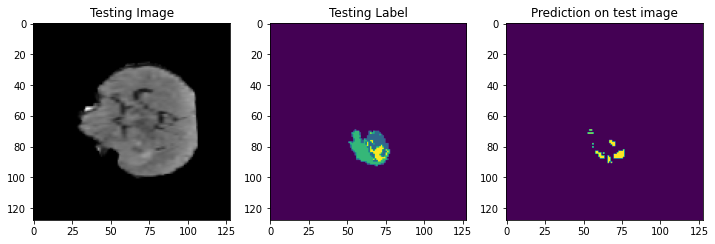

In [91]:
import matplotlib.pyplot as plt

img_num = 15
test_img = test_generator.__getitem__(img_num)[0]    #tuple(image,mask) -> 0: image
test_mask = test_generator.__getitem__(img_num)[1]   #tuple(image,mask) -> 1: mask
test_mask_argmax=np.argmax(test_mask, axis=4)[0,:,:,:]

test_prediction = model.predict(test_img)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

print("test_prediction_shape: " + str(test_prediction.shape))
print("test_prediction_argmax_shape: " + str(test_prediction_argmax.shape))
print(np.unique(test_prediction_argmax))
print("test_img_shape: " + str(test_img.shape))
print("test_mask_shape: " + str(test_mask.shape))
print("test_mask_argmax: " + str(test_mask_argmax.shape))

slice_index = 15  # Specify the index of the slice you want to display

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[0,:,:,slice_index,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,slice_index])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:,slice_index])
plt.show()
